# Determine which pairs of mutated positions are linked, and plot results

**Part 2 of the "linked mutations" analyses.**

In [1]:
%run "Header.ipynb"

In [2]:
import pickle
import shutil
import subprocess
import networkx as nx
from parse_sco import parse_sco
from linked_mutations_utils import (
    MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE, emptyListOf4
)

## Using the computed groups...

### Plot $|Reads(i, j)|$ vs. $\big(|Reads(i, -)| + |Reads(-, j)|\big)$

Minor considerations, based on how this data was computed in the first linked mutations notebook:

- We have already excluded mutated positions with less than some min coverage (current value is 1,000x).
- We have already excluded pairs more than some distance away from each other (current value is set in the config file; it might be infinity, in which case there effectively isn't a limit).
  - (Note that we do allow for pairs to span the start/end of the genome.)
  
We could also subset these pairs to just "consecutive" ones; however, doing that while allowing for pairs to span the start/end of the genome is tricky, so for simplicity's sake we just show all (potentially) valid pairs here.

On seq edge_6104.
....................................................................................................
Done with edge_6104!

On seq edge_1671.
....................................................................................................
Done with edge_1671!

On seq edge_2358.
....................................................................................................
Done with edge_2358!


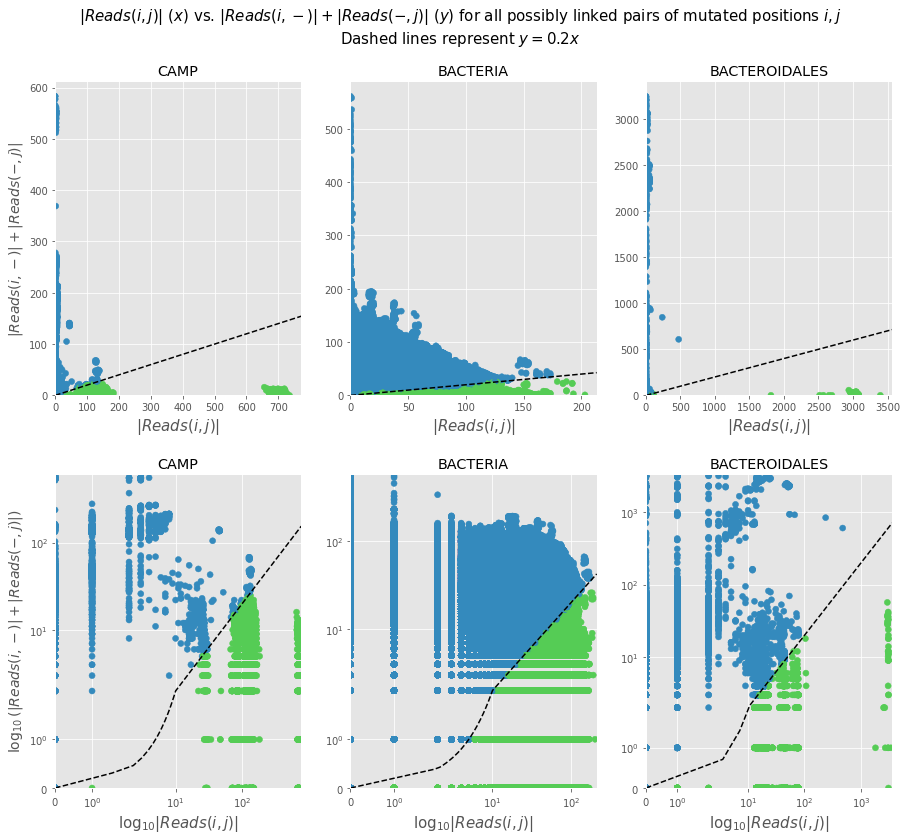

In [3]:
fig, axes = pyplot.subplots(2, 3, gridspec_kw={"hspace": 0.25})
for i, seq in enumerate(SEQS):
    print(f"On seq {seq}.")
    with open(f"pospair2groupcts/{seq}_pospair2groupcts.pickle", "rb") as pf:
        pospair2groupcts = pickle.load(pf)
    
    axNonLog = axes[0, i]
    axLog = axes[1, i]
    
    onehundredth = round(len(pospair2groupcts) / 100)
    plotx = []
    ploty = []
    plotcolor = []
    for ii, pospair in enumerate(sorted(pospair2groupcts.keys()), 1):
        
        # Crude progress bar.
        # This might occasionally print 99 or 101 dots instead of 100 dots per genome, but this is reasonable
        # enough. Just to reassure myself that this hasn't crashed my laptop.
        if ii % onehundredth == 0:
            print(".", end="")
            
        cts = pospair2groupcts[pospair]

        # Color pairs that are less than the 0.2 threshold specially (this is the remaining condition
        # for these pairs being linked, although we could also have non-consecutive mutations be linked
        # since the pairs we draw here are just a subset of the total pairs)
        if (cts[1] + cts[2]) < MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE * cts[0]:
            color = "#55cc55"
        else:
            color = SCATTERPLOT_PT_COLOR

        plotx.append(cts[0])
        ploty.append(cts[1] + cts[2])
        plotcolor.append(color)
            
    # Building up a list of x/y/color values, and then plotting that, is A TON faster than plotting each
    # point individually (like, calling ax.scatter() for each point). Hence why we do it here!
    # There are some other notebooks in this repo that do things the other way (e.g. as of writing the
    # "within-gene" plots plot each point individually) -- but those plots usually have at most a few thousand
    # points per plot, so it's not anywhere near as big a deal as it is here.
    axNonLog.scatter(plotx, ploty, c=plotcolor)
    axLog.scatter(plotx, ploty, c=plotcolor)
    print(f"\nDone with {seq}!")
    if i < 2:
        print("\n", end="")
    if i == 0:
        axNonLog.set_ylabel("$|Reads(i, -)| + |Reads(-, j)|$", fontsize=14)
        axLog.set_ylabel("$\log_{10} \, (|Reads(i, -)| + |Reads(-, j)|)$", fontsize=14)
        
    axNonLog.set_xlabel("$|Reads(i, j)|$", fontsize=15)
    axLog.set_xlabel("$\log_{10} |Reads(i, j)|$", fontsize=15)
        
    # Bound the left and bottom of each scatterplot at x = 0 and y = 0
    axNonLog.set_xlim(0)
    axNonLog.set_ylim(0)
    axLog.set_xlim(0)
    axLog.set_ylim(0)
    
    # Plot the line y = (MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE) * x
    # Represents the cutoff point for when or not we consider a pair of mutated positions to be linked.
    # Based on https://stackoverflow.com/a/43811762.
    xvals = axNonLog.get_xlim()
    yvals = [MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE * x for x in xvals]
    axNonLog.plot(xvals, yvals, "--", c="#000000")
    
    # Approximate the same line in the log plot. Just connect 
    maxx = max(axLog.get_xlim())
    dx = maxx / 1000
    lxvals = [dx * d for d in range(1001)]
    lyvals = [MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE * x for x in lxvals]
    axLog.plot(lxvals, lyvals, "--", c="#000000")
    
    axLog.set_xscale("symlog")
    axLog.set_yscale("symlog")
    
    axNonLog.set_title(seq2name[seq])
    axLog.set_title(seq2name[seq])
    
fig.suptitle(
    (
        "$|Reads(i, j)|$ ($x$) vs. $|Reads(i, -)| + |Reads(-, j)|$ ($y$) for all possibly linked pairs of mutated positions $i, j$\n"
        f"Dashed lines represent $y = {MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE:.1f}x$"
    ),
    fontsize="15",
    y=0.96
)
fig.set_size_inches(15, 13)
fig.savefig("figs/readsij_scatterplots.png", bbox_inches="tight")

## Define mutated positions as "linked" or not, and then create a graph for each genome

__Nodes:__ Mutated positions.

__Edges:__ Connect _linked_ mutated positions.

In [4]:
seq2graph = {}
for i, seq in enumerate(SEQS):
    g = nx.Graph()
    print(f"On seq {seq}...", end=" ")
    with open(f"pospair2groupcts/{seq}_pospair2groupcts.pickle", "rb") as pf:
        pospair2groupcts = pickle.load(pf)
        
    # Adding the same node twice doesn't hurt, so the lazy approach is ok
    # (not calling find_mutated_positions() from the utils file since that requires loading some big
    # JSONs into memory which will bork my laptop)
    for pair in pospair2groupcts:
        # The positions in pospair2groupcts are 0-indexed. To make working with gene data/etc. easier, convert
        # to 1-indexing.
        g.add_node(pair[0] + 1)
        g.add_node(pair[1] + 1)
        
        cts = pospair2groupcts[pair]
        if (cts[1] + cts[2]) < MAX_NONLINKED_MUTATED_FRACTION_NONINCLUSIVE * cts[0]:
            g.add_edge(pair[0] + 1, pair[1] + 1)
    
    seq2graph[seq] = g
    print("Created graph!")

On seq edge_6104... Created graph!
On seq edge_1671... Created graph!
On seq edge_2358... Created graph!


## Graph stats: what are the sizes of the $N$ largest components?

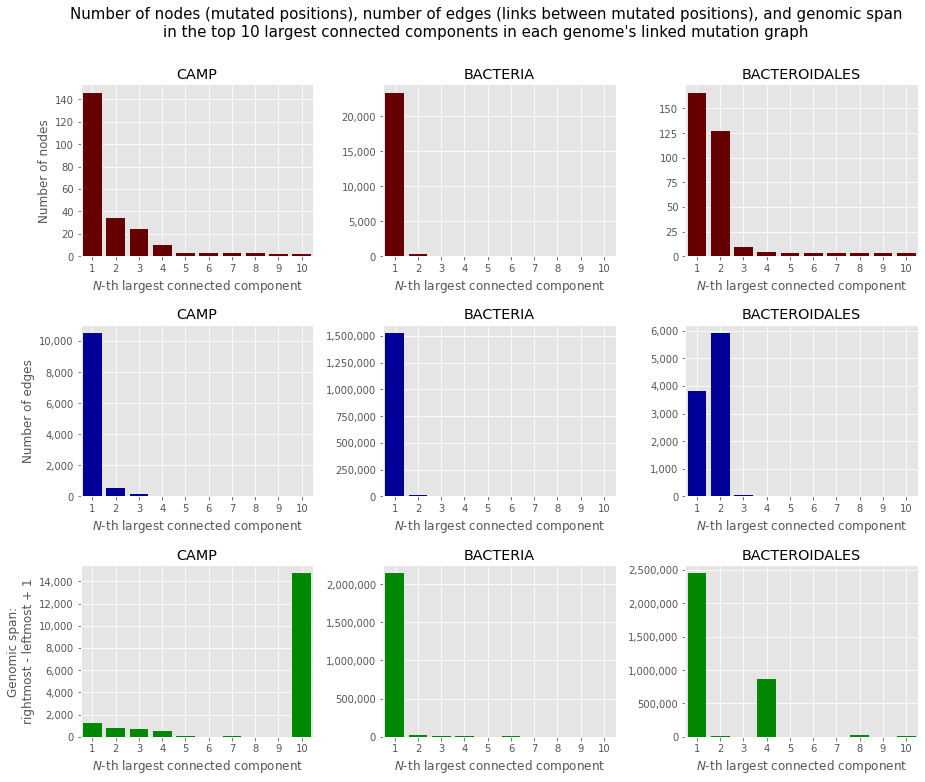

In [5]:
N = 10

seq2topN_cc_subgraphs = {}
seq2sorted_cc_node_lists = {}

gfig, gaxes = pyplot.subplots(3, 3, gridspec_kw={"hspace": 0.4, "wspace": 0.3})
for i, seq in enumerate(SEQS):
    g = seq2graph[seq]
    
    # nx.connected_components() returns a list of lists, where each inner list is just the nodes in
    # a given component.
    ccs = nx.connected_components(g)
    
    # Sort the connected component lists in descending order by number of nodes, and filter to the N ccs
    # with the largest #s of nodes (breaking ties arbitrarily)
    sorted_ccs = sorted(ccs, key=lambda cc: len(cc), reverse=True)
    topN_ccs = sorted_ccs[:N]
    seq2sorted_cc_node_lists[seq] = sorted_ccs
    
    topN_ccnodects = [len(cc) for cc in topN_ccs]
    
    # Induce subgraphs for each of the top N components
    cc_subgraphs = [g.subgraph(cc) for cc in topN_ccs]
    seq2topN_cc_subgraphs[seq] = cc_subgraphs
    
    # To figure out the number of edges in this component, just look at the number of edges in the
    # corresponding subgraph
    topN_ccedgects = [len(subg.edges) for subg in cc_subgraphs]
    
    # Figure out spans of each component
    topN_ccspans = [max(subg.nodes) - min(subg.nodes) + 1 for subg in cc_subgraphs]
    
    axN = gaxes[0, i]
    axN.bar(range(1, N + 1), topN_ccnodects, color="#660000")
    
    axE = gaxes[1, i]
    axE.bar(range(1, N + 1), topN_ccedgects, color="#000099")
    
    axS = gaxes[2, i]
    axS.bar(range(1, N + 1), topN_ccspans, color="#008800")
    
    if i == 0:
        axN.set_ylabel("Number of nodes")
        axE.set_ylabel("Number of edges")
        axS.set_ylabel("Genomic span:\nrightmost - leftmost + 1")
       
    for ax in (axN, axE, axS):
        ax.set_title(seq2name[seq])
        ax.set_xlabel("$N$-th largest connected component")
        use_thousands_sep(ax.get_yaxis())
        ax.set_xlim(0.5, N + 0.5)
        # Based kind of on https://stackoverflow.com/a/28289136
        ax.set_xticks(range(1, N + 1))
        
gfig.suptitle(
    (
        "Number of nodes (mutated positions), number of edges (links between mutated positions), and genomic span\n"
        f"in the top {N} largest connected components in each genome's linked mutation graph"
    ),
    fontsize="15",
    y=0.97
)
gfig.set_size_inches(15, 12)
gfig.savefig(f"figs/linkedmutgraph_top{N}cc_sizes.png", bbox_inches="tight")

## Create Graphviz DOT files for the top $N$ largest components, coloring nodes by gene; visualize as PNG files

In [6]:
def get_parent_gene_info_of_position(pos, genes_df):
    """Returns information about the parent gene(s) of a position.
    
    Parameters
    ==========
    
    pos: int
        1-indexed position in a genome.
        
    genes_df: pd.DataFrame
        Result from calling parse_sco().
        
    Returns
    =======
    
    parent_info: (int, str, None)
        If this position only has one parent gene, returns an integer corresponding to the
        gene number in the Prodigal .SCO file.
        
        If this position has multiple parent genes (due to gene overlap),
        returns the string "Multiple".
        
        If this position has no parent genes (due to this position being located in a non-coding
        region of the genome), returns None.
    """
    parent_gene = None
    for gene in genes_df.itertuples():
        if pos >= int(gene.LeftEnd) and pos <= int(gene.RightEnd):
            if parent_gene is None:
                parent_gene = int(gene.Index)
            else:
                return "Multiple"
    return parent_gene

# Get the tab20 color map. This returns an object that we can call with, e.g. (0) to get the first
# color, (1) to get the second color, etc. See https://stackoverflow.com/a/25408562.
# (List of matplotlib color maps: https://matplotlib.org/stable/gallery/color/colormap_reference.html)
cmap = matplotlib.cm.get_cmap("tab20")
colors = [cmap(i) for i in range(20)]
hexcolors = [matplotlib.colors.to_hex(c) for c in colors]

# Ensure that certain genes we care about have special colors that are unique to this gene (in the context
# of the other genes in a given genome's graph).
#
# This is a pretty sloppy way of doing this but... it works
# 0-indexed positions based on https://matplotlib.org/stable/gallery/color/colormap_reference.html's
# plot of tab20: e.g. 18 corresponds to the second-from-the-last color, a bright turqoise
# and 10 is dark brown, 12 is bright pink, 6 is dark red
seq2genes_we_esp_care_about2specialgenecolors = {
    "edge_6104": {1217: hexcolors[10], 970: hexcolors[12]},
    "edge_1671": {868: hexcolors[18]},
    "edge_2358": {2562: hexcolors[6]}
}

for seq in SEQS:
    genes_df = parse_sco("../seqs/genes/{}.sco".format(seq))
    available_hex_colors = hexcolors[:]
    for color in seq2genes_we_esp_care_about2specialgenecolors[seq].values():
        available_hex_colors.remove(color)
        
    total_seq_graph_gv = f"graph {seq}"
    total_seq_graph_gv += " {\n"
    total_seq_graph_gv += '\toverlap="prism50";\n'
    total_seq_graph_gv += '\toutputorder="edgesfirst";\n'
    
    for cci in range(N):
        
        subg = seq2topN_cc_subgraphs[seq][cci]
        
        numnodes = len(subg.nodes)
        numedges = len(subg.edges)
        print(f"{seq2name[seq]}, cc {cci + 1}, {numnodes} nodes, {numedges} edges")
        
        graph_id = f"{seq2name[seq]}_cc{cci + 1}"
        gv = f"graph {graph_id}"
        gv += " {\n"
        
        # Spend extra time trying to reduce node overlap
        gv += '\toverlap="prism50";\n'
        
        # Draw edges below nodes, so that it's easier to see all nodes in a component
        gv += '\toutputorder="edgesfirst";\n'
        
        # Add a nice label to each graph! https://stackoverflow.com/a/11594722
        gv += f'\tlabel="{seq2name[seq]}, component {cci + 1}: {numnodes:,} nodes, {numedges:,} edges";\n'
        gv += '\tlabelloc="t";\n'
        gv += '\tfontsize=24;\n'
                
        for n in subg.nodes:
            parent_gene_info = get_parent_gene_info_of_position(n, genes_df)
            fontcolor = "#000000"
            if parent_gene_info is None:
                # Not-in-any-genes color is white (no overlap with the tab20 color map)
                genecolor = "#ffffff"
            elif parent_gene_info == "Multiple":
                # In-mulitple-genes color is black (no overlap with the tab20 color map)
                genecolor = "#000000"
                # For contrast, color the font white
                fontcolor = "#ffffff"
                # Just for debugging
                print(f"For reference: pos {n} in multiple genes in seq {seq2name[seq]}")
            else:
                # Nice! This position is unique to one gene.
                if parent_gene_info in seq2genes_we_esp_care_about2specialgenecolors[seq]:
                    genecolor = seq2genes_we_esp_care_about2specialgenecolors[seq][parent_gene_info]
                else:
                    genecolor = available_hex_colors[(parent_gene_info - 1) % len(available_hex_colors)]
            nodedecl = f'\t"{n:,}" [style="filled", fillcolor="{genecolor}", fontcolor="{fontcolor}"];\n'
            gv += nodedecl
            total_seq_graph_gv += nodedecl
            
        for e in subg.edges:
            edgedecl = f'\t"{e[0]:,}" -- "{e[1]:,}";\n'
            gv += edgedecl
            total_seq_graph_gv += edgedecl
            
        gv += "}"
        fnbase = f"graphs/{graph_id}"
        with open(fnbase + ".gv", "w") as ccgraphgvfile:
            ccgraphgvfile.write(gv)
            
        # Many of these components (esp for individual genes) are "complete" or nearly-complete graphs, for
        # which circular layouts are useful. However, trying to do circular layout on huge graphs makes my
        # computer angry. So we set an arbitrary upper limit on the number of edges: if this component has
        # more than some # of edges, use the fast but arguably-less-pretty sfdp layout. Otherwise, use circo
        # to do circular layout.
        if len(subg.edges) > 999:
            prog = "sfdp"
        else:
            prog = "circo"
        with open(fnbase + ".png", "w") as ccgraphpngfile:
            subprocess.run([
                prog,
                fnbase + ".gv",
                "-Tpng"
            ],
                stdout=ccgraphpngfile
            )
            
    total_seq_graph_gv += "}"
    fnbase = f"graphs/{seq2name[seq]}_top{N}_together"
    print(f"Plotting full top {N} graph for {seq2name[seq]}...")
    with open(fnbase + ".gv", "w") as ccgraphgvfile:
        ccgraphgvfile.write(total_seq_graph_gv)
    with open(fnbase + ".png", "w") as ccgraphpngfile:
        subprocess.run([
            "sfdp",
            fnbase + ".gv",
            "-Tpng"
        ],
            stdout=ccgraphpngfile
        )

CAMP, cc 1, 146 nodes, 10514 edges
CAMP, cc 2, 34 nodes, 561 edges
CAMP, cc 3, 24 nodes, 136 edges
CAMP, cc 4, 10 nodes, 31 edges
CAMP, cc 5, 3 nodes, 3 edges
CAMP, cc 6, 3 nodes, 2 edges
CAMP, cc 7, 3 nodes, 3 edges
CAMP, cc 8, 3 nodes, 3 edges
CAMP, cc 9, 2 nodes, 1 edges
CAMP, cc 10, 2 nodes, 1 edges
Plotting full top 10 graph for CAMP...
BACTERIA, cc 1, 23381 nodes, 1527849 edges
For reference: pos 268982 in multiple genes in seq BACTERIA
For reference: pos 306900 in multiple genes in seq BACTERIA
For reference: pos 1441006 in multiple genes in seq BACTERIA
For reference: pos 1938968 in multiple genes in seq BACTERIA
For reference: pos 2092363 in multiple genes in seq BACTERIA
For reference: pos 2111109 in multiple genes in seq BACTERIA


KeyboardInterrupt: 

## Find "fates" of genes we care about in the graphs

In [7]:
seq2genes_we_esp_care_about = {
    "edge_6104": [1217, 970],
    "edge_1671": [868],
    "edge_2358": [2562]
}
for seq in SEQS:
    genes_df = parse_sco("../seqs/genes/{}.sco".format(seq))
    genenums = seq2genes_we_esp_care_about[seq]
    for gn in genenums:
        ccs_with_positions_in_this_gene = []
        gene_data = genes_df.loc[gn]
        leftend = gene_data["LeftEnd"]
        rightend = gene_data["RightEnd"]
        for cci, cc in enumerate(seq2sorted_cc_node_lists[seq], 1):
            for node in cc:
                if node >= leftend and node <= rightend:
                    ccs_with_positions_in_this_gene.append(cci)
                    # Once we've observed this we can move on to the next cc
                    break
        print(f"Gene {gn} in {seq2name[seq]}: mutated positions are located in cc(s) {ccs_with_positions_in_this_gene}.")
        
        # Copy plots to figs/ as needed.
        for cci in ccs_with_positions_in_this_gene:
            if cci <= N:
                shutil.copyfile(
                    f"graphs/{seq2name[seq]}_cc{cci}.png",
                    f"figs/{seq2name[seq]}_cc{cci}.png"
                )
                print(f"Copied cc {cci}'s plot to figs/ so you can include it in the paper.")
            else:
                print(f"Couldn't copy cc {cci} to figs/ since wasn't plotted. Marcus needs to go plot it.")
        print("=" * 79)

Gene 1217 in CAMP: mutated positions are located in cc(s) [2].
Copied cc 2's plot to figs/ so you can include it in the paper.
Gene 970 in CAMP: mutated positions are located in cc(s) [1, 9].
Copied cc 1's plot to figs/ so you can include it in the paper.
Copied cc 9's plot to figs/ so you can include it in the paper.
Gene 868 in BACTERIA: mutated positions are located in cc(s) [1].
Copied cc 1's plot to figs/ so you can include it in the paper.
Gene 2562 in BACTEROIDALES: mutated positions are located in cc(s) [1].
Copied cc 1's plot to figs/ so you can include it in the paper.
